# Brain Tumor Classification Without Segmentation

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow_addons as tfa
import os
import cv2

### Data Preparation

In [3]:
def get_df(path):
    classes, class_paths = zip(*[
        (label, os.path.join(path, label, image))
        for label in os.listdir(path) if os.path.isdir(os.path.join(path, label))
        for image in os.listdir(os.path.join(path, label))
    ])

    tr_df = pd.DataFrame({"Path": class_paths, "Class": classes})
    return tr_df

In [4]:
train_df = get_df("../data/original/original/Training")
test_df = get_df("../data/original/original/Testing")

### Data Preprocessing

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
valid_df, test_df = train_test_split(test_df, test_size = 0.5, random_state = 42, stratify = test_df["Class"], shuffle = True)

In [7]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255,
    # brightness_range = [0.8, 1.2],
)

In [8]:
train_set = train_datagen.flow_from_dataframe(
    train_df,
    x_col = "Path",
    y_col = "Class",
    batch_size = 32,
    target_size = (224, 224),
    shuffle = True,
    color_mode = "grayscale"
)

Found 5712 validated image filenames belonging to 4 classes.


In [9]:
valid_set = train_datagen.flow_from_dataframe(
    valid_df,
    x_col = "Path",
    y_col = "Class",
    batch_size = 32,
    target_size = (224, 224),
    shuffle = True,
    color_mode = "grayscale"
)

Found 655 validated image filenames belonging to 4 classes.


In [10]:
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255
)

In [11]:
test_set = train_datagen.flow_from_dataframe(
    test_df,
    x_col = "Path",
    y_col = "Class",
    batch_size = 32,
    target_size = (224, 224),
    shuffle = False,
    color_mode = "grayscale"
)

Found 656 validated image filenames belonging to 4 classes.


### Modeling

In [12]:
from sklearn.metrics import classification_report, confusion_matrix

In [13]:
y_true = test_set.classes
class_labels = list(test_set.class_indices.keys())

In [14]:
y_true_one_hot = tf.keras.utils.to_categorical(y_true, num_classes = 4)

##### 1. CNN

In [16]:
def get_feature_extractor():
    cnn = tf.keras.models.Sequential()    

    # Convulational Layer 1
    cnn.add(tf.keras.layers.Conv2D(
        filters = 32, 
        kernel_size = 3, 
        input_shape = [224, 224, 1], 
        kernel_regularizer = tf.keras.regularizers.l2(0.00005),
        padding = "same"
    ))
    cnn.add(tf.keras.layers.BatchNormalization())
    cnn.add(tf.keras.layers.ReLU())

    # Pooling Layer 1
    cnn.add(tf.keras.layers.MaxPool2D(
        pool_size = 2, 
        strides = 2
    ))

    # Convulational Layer 2
    cnn.add(tf.keras.layers.Conv2D(
        filters = 64, 
        kernel_size = 3, 
        kernel_regularizer = tf.keras.regularizers.l2(0.00005),
        padding = "same"
    ))
    cnn.add(tf.keras.layers.BatchNormalization())
    cnn.add(tf.keras.layers.ReLU())

    # Pooling Layer 2
    cnn.add(tf.keras.layers.MaxPool2D(
        pool_size = 2, 
        strides = 2
    ))

    # Convulational Layer 3
    cnn.add(tf.keras.layers.Conv2D(
        filters = 128, 
        kernel_size = 3, 
        kernel_regularizer = tf.keras.regularizers.l2(0.00005),
        padding = "same"
    ))
    cnn.add(tf.keras.layers.BatchNormalization())
    cnn.add(tf.keras.layers.ReLU())

    # Pooling Layer 3
    cnn.add(tf.keras.layers.MaxPool2D(
        pool_size = 2, 
        strides = 2
    ))

    # Convulational Layer 4
    cnn.add(tf.keras.layers.Conv2D(
        filters = 128, 
        kernel_size = 3, 
        kernel_regularizer = tf.keras.regularizers.l2(0.00005),
        padding = "same"
    ))
    cnn.add(tf.keras.layers.BatchNormalization())
    cnn.add(tf.keras.layers.ReLU())

    # Pooling Layer 4
    cnn.add(tf.keras.layers.MaxPool2D(
        pool_size = 2, 
        strides = 2
    ))  
 
    # Flatten Layer 
    cnn.add(tf.keras.layers.Flatten())  

    return cnn  

In [19]:
cnn = get_feature_extractor()

# Fully Connected Layer 1
cnn.add(tf.keras.layers.Dense(
    units = 128,
    kernel_regularizer = tf.keras.regularizers.l2(0.00005)
))
cnn.add(tf.keras.layers.BatchNormalization())
cnn.add(tf.keras.layers.ReLU())


# Droput Layer
cnn.add(tf.keras.layers.Dropout(0.4))

# Output Layer
cnn.add(tf.keras.layers.Dense(
    units = 4, 
    activation = "softmax"
))

In [20]:
cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 224, 224, 32)      320       
                                                                 
 batch_normalization_5 (Batc  (None, 224, 224, 32)     128       
 hNormalization)                                                 
                                                                 
 re_lu_5 (ReLU)              (None, 224, 224, 32)      0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 112, 112, 32)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 batch_normalization_6 (Batc  (None, 112, 112, 64)    

In [21]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor = "val_loss", 
    patience = 10, 
    restore_best_weights = True
)

In [22]:
cnn.compile(
    optimizer = tf.keras.optimizers.Adam(
        learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate = 1e-4,
            decay_steps = 1000,
            decay_rate = 0.95
        )
    ), 
    loss = "categorical_crossentropy", 
    metrics = [tf.keras.metrics.Recall()]
)

In [23]:
history = cnn.fit(
    train_set, 
    validation_data = valid_set, 
    epochs = 100, 
    callbacks = [early_stopping]
)

Epoch 1/100
179/179 [==============================] - 19s 86ms/step - loss: 0.5190 - recall: 0.7824 - val_loss: 2.4590 - val_recall: 0.2336
Epoch 2/100
179/179 [==============================] - 15s 83ms/step - loss: 0.2670 - recall: 0.9074 - val_loss: 1.0666 - val_recall: 0.4351
Epoch 3/100
179/179 [==============================] - 15s 83ms/step - loss: 0.1715 - recall: 0.9485 - val_loss: 0.4054 - val_recall: 0.8305
Epoch 4/100
179/179 [==============================] - 15s 83ms/step - loss: 0.1288 - recall: 0.9676 - val_loss: 0.2730 - val_recall: 0.9145
Epoch 5/100
179/179 [==============================] - 15s 86ms/step - loss: 0.0900 - recall: 0.9858 - val_loss: 0.1933 - val_recall: 0.9328
Epoch 6/100
179/179 [==============================] - 15s 84ms/step - loss: 0.0745 - recall: 0.9905 - val_loss: 0.1384 - val_recall: 0.9557
Epoch 7/100
179/179 [==============================] - 15s 83ms/step - loss: 0.0649 - recall: 0.9935 - val_loss: 0.1348 - val_recall: 0.9634
Epoch 8/100
1

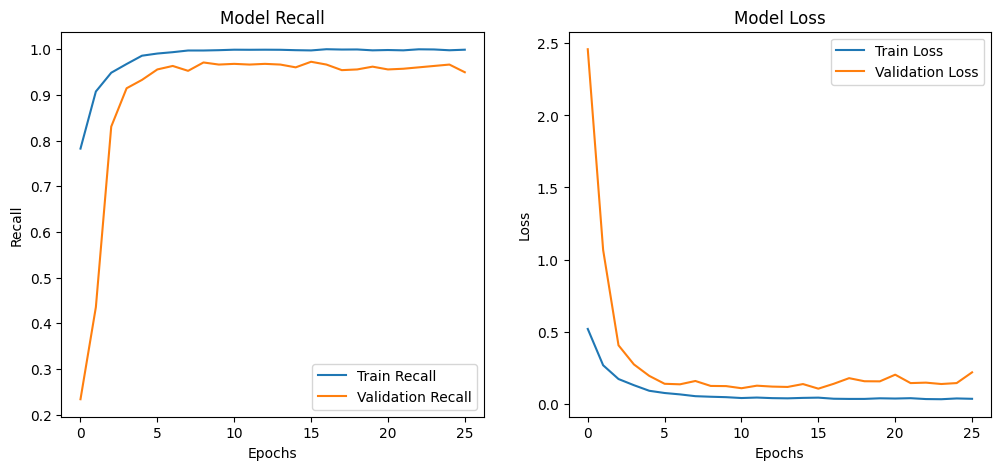

In [24]:
fig, axes = plt.subplots(1, 2, figsize = (12, 5))

axes[0].plot(history.history["recall"], label = "Train Recall")
axes[0].plot(history.history["val_recall"], label = "Validation Recall")
axes[0].set_title("Model Recall")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Recall")
axes[0].legend()

axes[1].plot(history.history["loss"], label = "Train Loss")
axes[1].plot(history.history["val_loss"], label = "Validation Loss")
axes[1].set_title("Model Loss")
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Loss")
axes[1].legend()

plt.show()

In [25]:
y_prob_cnn = cnn.predict(test_set)
y_pred_cnn= np.argmax(y_prob_cnn, axis = 1)

21/21 [==============================] - 1s 33ms/step


In [26]:
print(confusion_matrix(y_true, y_pred_cnn))
print(classification_report(y_true, y_pred_cnn, target_names = class_labels))

[[145   5   0   0]
 [  9 140   2   2]
 [  1   0 202   0]
 [  0   0   0 150]]
              precision    recall  f1-score   support

      glioma       0.94      0.97      0.95       150
  meningioma       0.97      0.92      0.94       153
     notumor       0.99      1.00      0.99       203
   pituitary       0.99      1.00      0.99       150

    accuracy                           0.97       656
   macro avg       0.97      0.97      0.97       656
weighted avg       0.97      0.97      0.97       656



##### CNN-XGBoost

In [21]:
import numpy as np
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

In [17]:
feature_extractor = get_feature_extractor()

In [24]:
def extract_features(df, label_encoder, batch_size=32):
    features = []
    labels = []

    image_paths = df["Path"].tolist()
    classes = df["Class"].tolist()

    for i in tqdm(range(0, len(df), batch_size)):
        batch_paths = image_paths[i:i+batch_size]
        batch_imgs = []

        for path in batch_paths:
            img = tf.keras.preprocessing.image.load_img(path, target_size=(224, 224), color_mode="grayscale")
            img_array = tf.keras.preprocessing.image.img_to_array(img)
            batch_imgs.append(img_array)

        batch_imgs = np.array(batch_imgs)
        batch_features = feature_extractor.predict(batch_imgs, verbose=0)

        features.extend(batch_features)
        labels.extend(classes[i:i+batch_size])

    X = np.array(features)
    y = label_encoder.transform(labels)
    return X, y

In [19]:
label_encoder = LabelEncoder()
label_encoder.fit(train_df['Class']) 

LabelEncoder()

In [25]:
X_train, y_train = extract_features(train_df, label_encoder)
X_valid, y_valid = extract_features(valid_df, label_encoder)
X_test, y_test = extract_features(test_df, label_encoder)

100%|██████████| 21/21 [00:01<00:00, 12.40it/s]


In [26]:
xgb = XGBClassifier(
    objective = 'multi:softmax',
    num_class = 4,
    eval_metric = 'mlogloss',
    use_label_encoder = False,
    early_stopping_rounds=10    
)

xgb.fit(X_train, y_train, eval_set = [(X_valid, y_valid)], verbose = True)

c:\Users\PC\anaconda3\envs\main-gpu\lib\site-packages\xgboost\callback.py:386: UserWarning: [19:40:16] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


[0]	validation_0-mlogloss:1.02141
[1]	validation_0-mlogloss:0.82043
[2]	validation_0-mlogloss:0.68174
[3]	validation_0-mlogloss:0.57996
[4]	validation_0-mlogloss:0.49935
[5]	validation_0-mlogloss:0.43757
[6]	validation_0-mlogloss:0.39298
[7]	validation_0-mlogloss:0.35198
[8]	validation_0-mlogloss:0.32076
[9]	validation_0-mlogloss:0.29461
[10]	validation_0-mlogloss:0.27627
[11]	validation_0-mlogloss:0.26271
[12]	validation_0-mlogloss:0.24782
[13]	validation_0-mlogloss:0.23797
[14]	validation_0-mlogloss:0.22926
[15]	validation_0-mlogloss:0.22292
[16]	validation_0-mlogloss:0.21621
[17]	validation_0-mlogloss:0.21186
[18]	validation_0-mlogloss:0.20788
[19]	validation_0-mlogloss:0.20505
[20]	validation_0-mlogloss:0.20106
[21]	validation_0-mlogloss:0.19899
[22]	validation_0-mlogloss:0.19650
[23]	validation_0-mlogloss:0.19611
[24]	validation_0-mlogloss:0.19216
[25]	validation_0-mlogloss:0.18979
[26]	validation_0-mlogloss:0.18976
[27]	validation_0-mlogloss:0.18726
[28]	validation_0-mlogloss:0.1

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None, num_class=4, ...)

In [27]:
y_pred_xgb = xgb.predict(X_test)

In [28]:
print(confusion_matrix(y_true, y_pred_xgb))
print(classification_report(y_true, y_pred_xgb, target_names = label_encoder.classes_))

[[131  16   0   3]
 [  3 144   6   0]
 [  0   0 203   0]
 [  0   1   0 149]]
              precision    recall  f1-score   support

      glioma       0.98      0.87      0.92       150
  meningioma       0.89      0.94      0.92       153
     notumor       0.97      1.00      0.99       203
   pituitary       0.98      0.99      0.99       150

    accuracy                           0.96       656
   macro avg       0.96      0.95      0.95       656
weighted avg       0.96      0.96      0.96       656

